# Copyright
<pre>
Jelen forráskód a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott
"Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült.

A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A forráskódot GPLv3 licensz védi. Újrafelhasználás esetén lehetőség szerint kérjük
az alábbi szerzőt értesíteni.

2018 (c) Csapó Tamás Gábor (csapot kukac tmit pont bme pont hu),
Gyires-Tóth Bálint, Zainkó Csaba


Original Generative Adversarial Network example from:

Links:
    [Keras-GAM] https://github.com/eriklindernoren/Keras-GAN
</pre>

In [0]:
# original example from https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py

In [1]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np


Using TensorFlow backend.


In [0]:
class GAN_image():

  # diszkriminátor hálózat: képről bináris döntés,
  # hogy valódi vagy hamis
  def build_discriminator(self):
    model = Sequential()
    
    model.add(Flatten(input_shape = self.img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2)) # LeakyReLU vs sima ReLU
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    model.summary()
    
    img = Input(shape=self.img_shape)
    
    validity = model(img)
    
    return Model(img, validity)
  
  # generátor hálózat: zajból kép generálás
  def build_generator(self):
    model = Sequential()
    
    model.add(Dense(256, input_dim = self.latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8)) # BatchNorm: előadásokon
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(self.img_shape), activation='tanh'))
    model.add(Reshape(self.img_shape))
    
    model.summary()
    
    noise = Input(shape=(self.latent_dim,))
    img = model(noise)
    
    return Model(noise, img)
  
  
  def __init__(self):
    self.img_rows = 28
    self.img_cols = 28
    self.channels = 1
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    self.latent_dim = 100
    
    optimizer = Adam(0.0002, 0.5)
    
    # diszkriminátor build és compile
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss = 'binary_crossentropy',
                              optimizer=optimizer,
                              metrics=['accuracy'])
    
    # generátor build
    self.generator = self.build_generator()
    
    # generátor: zaj bemenetből képet készít
    z = Input(shape=(self.latent_dim,))
    img = self.generator(z)
    
    # együttes modell - itt csak a generátort tanítjuk
    self.discriminator.trainable = False
    
    # diszkriminátor: generált képekről eldönti, hogy valódiak-e
    validity = self.discriminator(img)
    
    # együttes modell
    # cél: a generátor megtanulja, hogyan csaphatja be a diszkriminátort
    self.combined = Model(z, validity)
    self.combined.compile(loss = 'binary_crossentropy',
                         optimizer=optimizer)

  


In [0]:
# tanítás paraméterek
epochs = 30000
batch_size = 128
sample_interval = 50

In [4]:
gan = GAN_image()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

In [0]:
# adatok betöltése
from keras.datasets import mnist
(x_train, _), (_, _) = mnist.load_data()

# skálázás -1 és 1 közé
x_train = x_train / 127.5 - 1
x_train = np.expand_dims(x_train, axis = 3) # legyen channel dim is

# diszkriminátor kimenetek
valid = np.ones((batch_size, 1)) # D(x)    = 1
fake = np.zeros((batch_size, 1)) # D(G(z)) = 0


In [0]:
# generált képek kirajzolása

from IPython import display

def plot_images(gan, epoch):
  r, c = 5,5
  noise = np.random.normal(0, 1, (r * c, gan.latent_dim))
  gen_imgs = gan.generator.predict(noise)
  
  # rescale to 0-1 (from -1 -- 1)
  gen_imgs = 0.5 * gen_imgs + 0.5
  
  plt.title('epoch ' + str(epoch))
  fig, ax = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      ax[i,j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      ax[i,j].axis('off')
      cnt += 1
  
  display.display(plt.gcf())
      

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 loss_D 0.97506046 loss_G 0.8523914


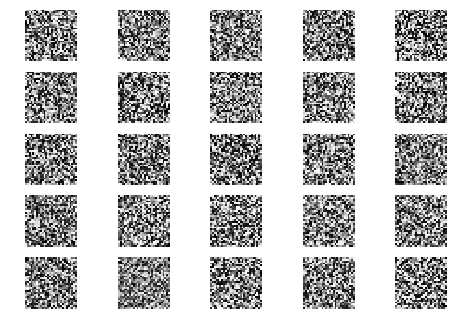

100 loss_D 0.33851838 loss_G 2.961826


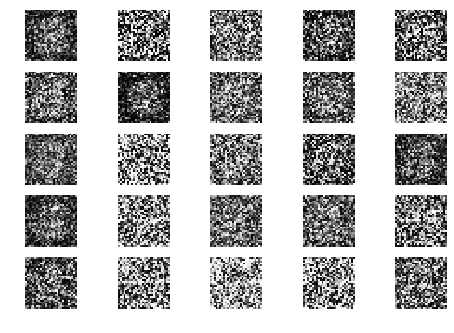

200 loss_D 0.38867825 loss_G 2.2170951


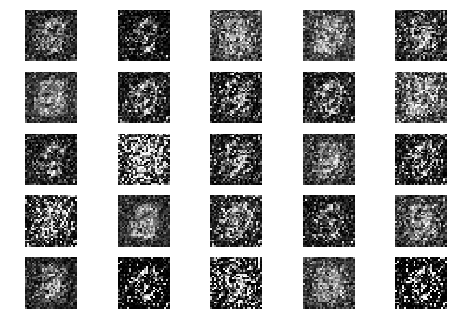

300 loss_D 0.68575865 loss_G 0.651555


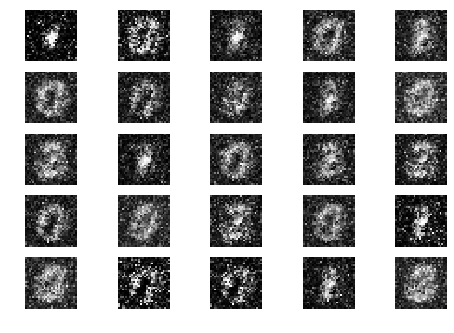

400 loss_D 0.68234074 loss_G 0.67499495


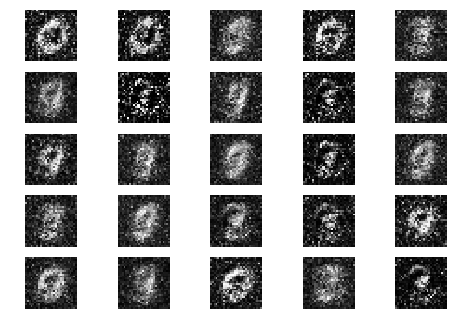

500 loss_D 0.6544869 loss_G 0.71066666


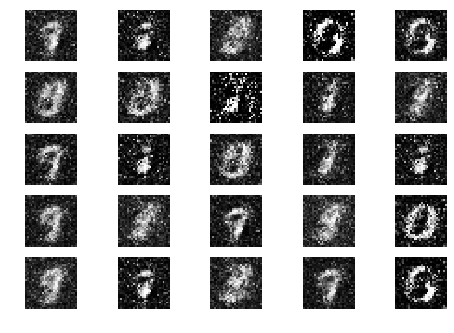

600 loss_D 0.63249564 loss_G 0.7572585


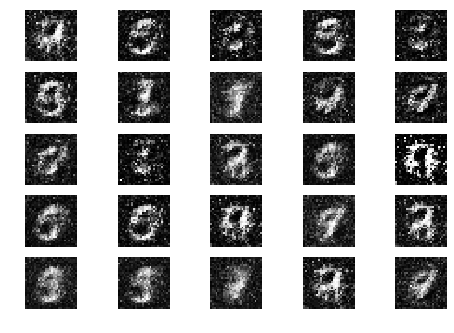

700 loss_D 0.6460618 loss_G 0.7579763


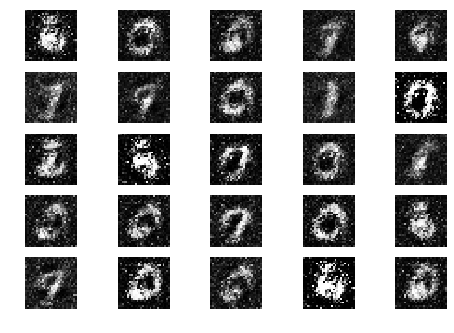

800 loss_D 0.60932565 loss_G 0.85432756


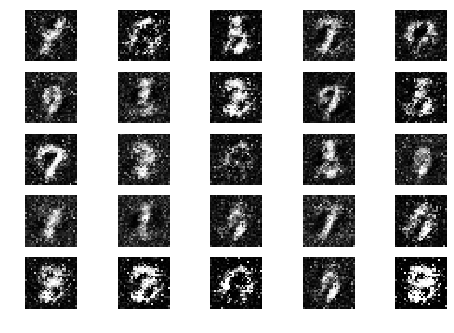

900 loss_D 0.6253165 loss_G 0.84487635


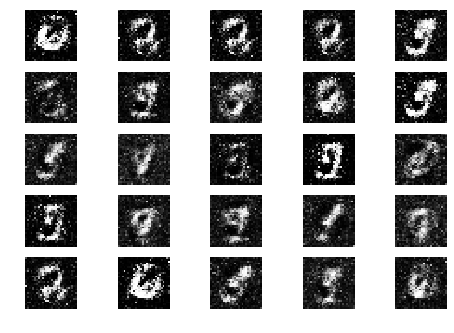

1000 loss_D 0.6281804 loss_G 0.9037122


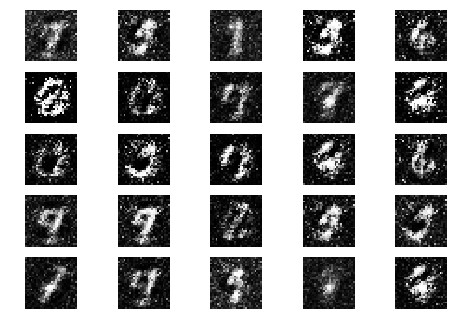

1100 loss_D 0.5588586 loss_G 1.0012351


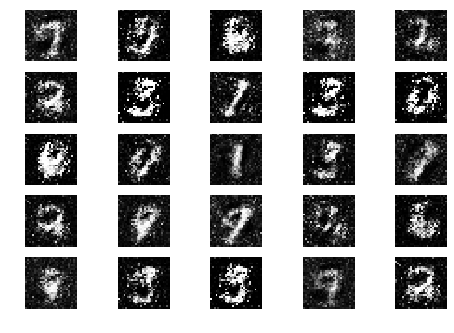

1200 loss_D 0.536155 loss_G 1.0474095


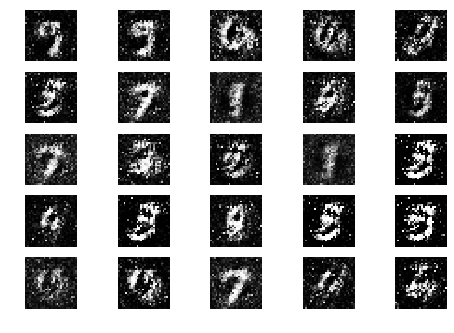

1300 loss_D 0.5827433 loss_G 1.0519131


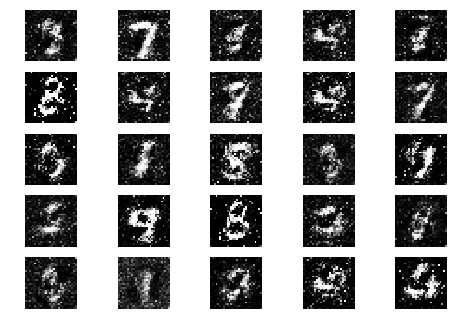

1400 loss_D 0.60217166 loss_G 1.0193646


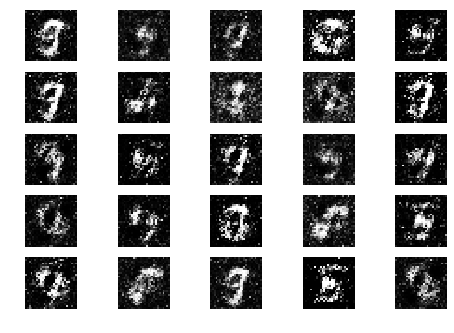

1500 loss_D 0.58152044 loss_G 1.0345691


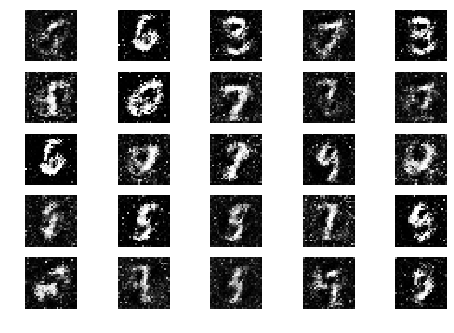

1600 loss_D 0.55043304 loss_G 1.0571244


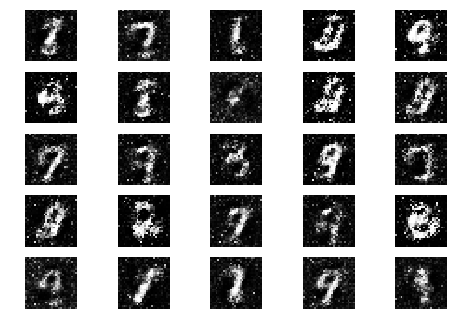

1700 loss_D 0.588607 loss_G 0.9934177


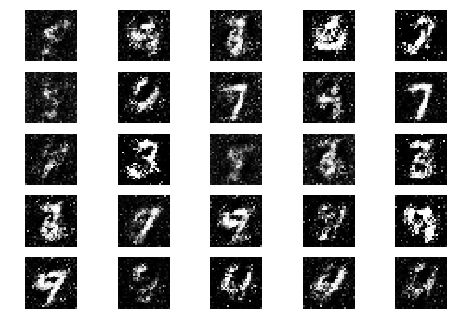

1800 loss_D 0.5748402 loss_G 1.0037577


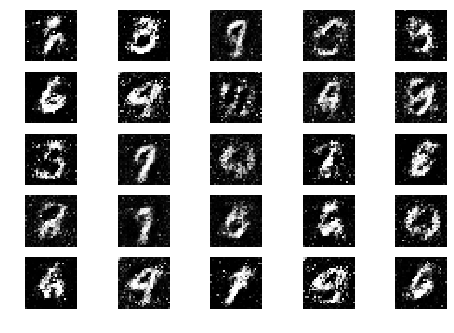

1900 loss_D 0.5834795 loss_G 0.9693934


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


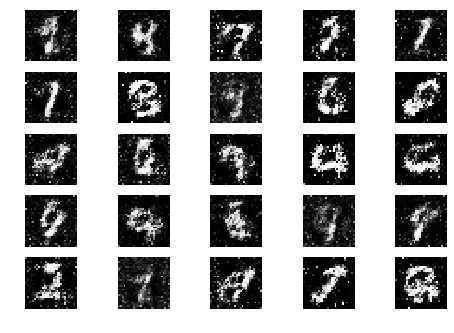

2000 loss_D 0.59843343 loss_G 0.99570966


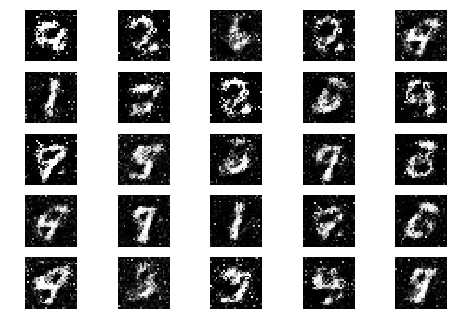

2100 loss_D 0.5957428 loss_G 0.9656316


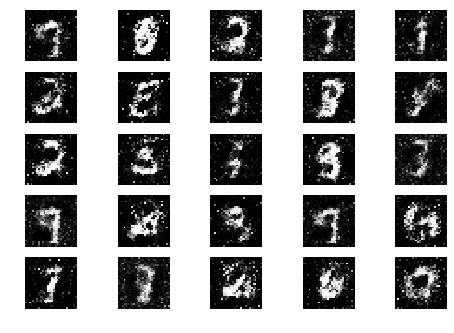

2200 loss_D 0.6197685 loss_G 0.9324142


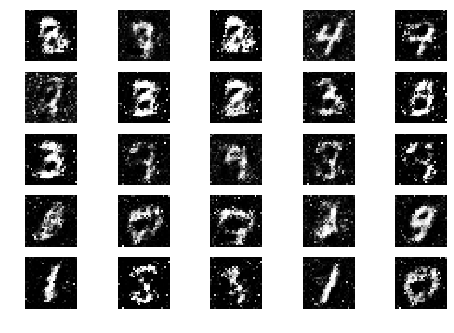

2300 loss_D 0.5673473 loss_G 1.032845


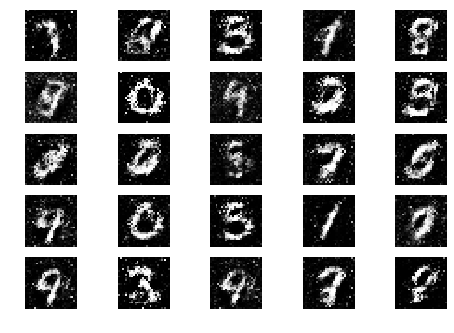

2400 loss_D 0.6116532 loss_G 0.96279657


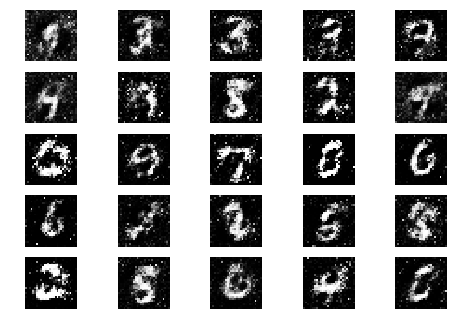

2500 loss_D 0.6121036 loss_G 1.0330371


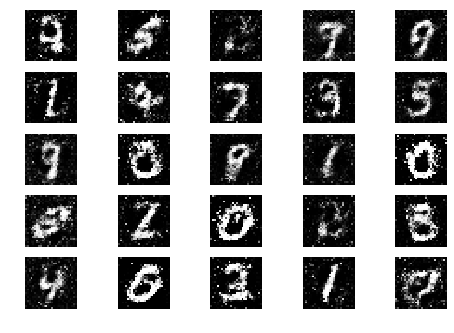

2600 loss_D 0.5854249 loss_G 1.0006186


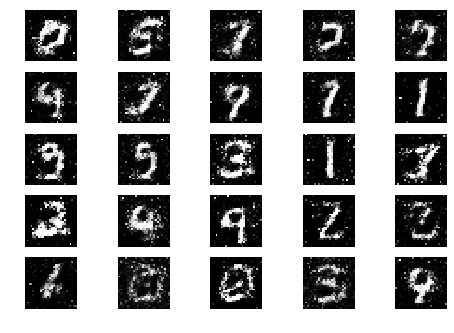

2700 loss_D 0.5808399 loss_G 1.0115708


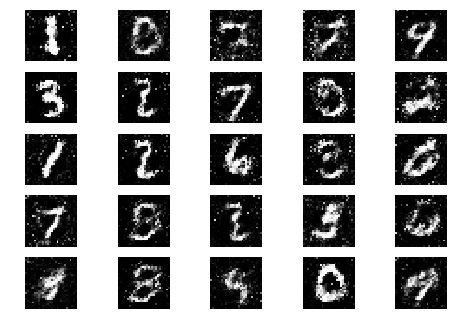

2800 loss_D 0.6059464 loss_G 0.982308


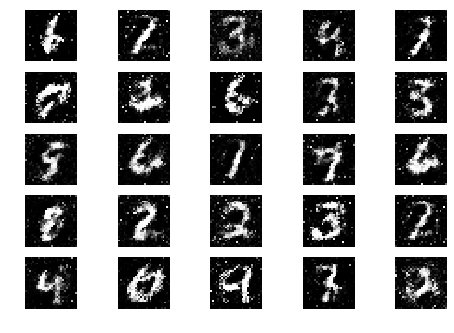

2900 loss_D 0.6076462 loss_G 0.97007096


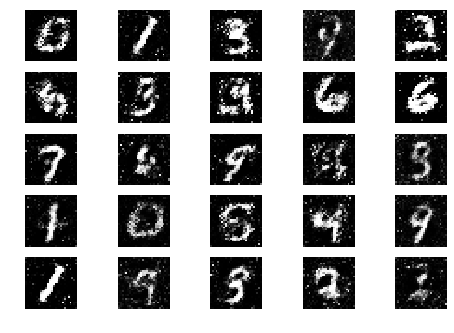

3000 loss_D 0.61178994 loss_G 0.9624442


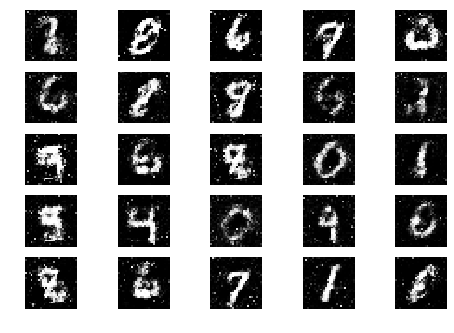

3100 loss_D 0.53841174 loss_G 1.0354828


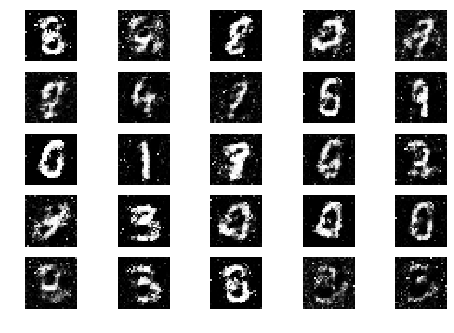

3200 loss_D 0.6306304 loss_G 0.9144254


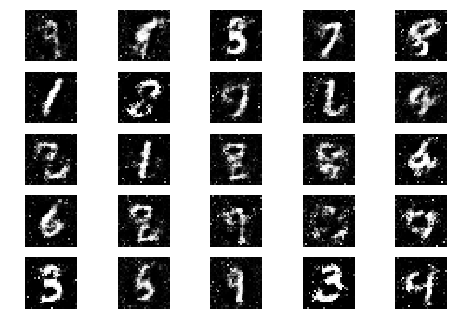

3300 loss_D 0.61012894 loss_G 0.9486828


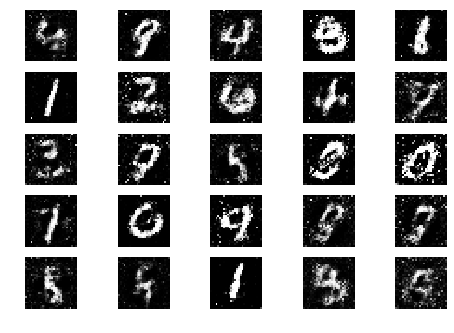

3400 loss_D 0.63095534 loss_G 0.9428866


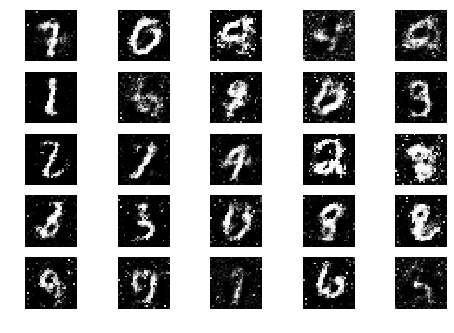

3500 loss_D 0.6649764 loss_G 0.8968056


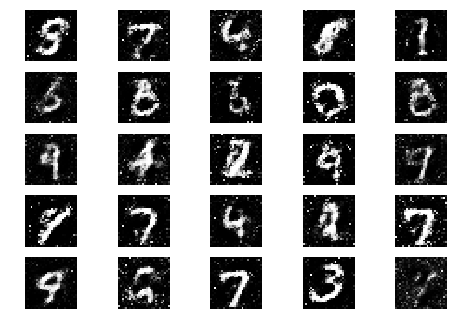

3600 loss_D 0.6188413 loss_G 0.94996953


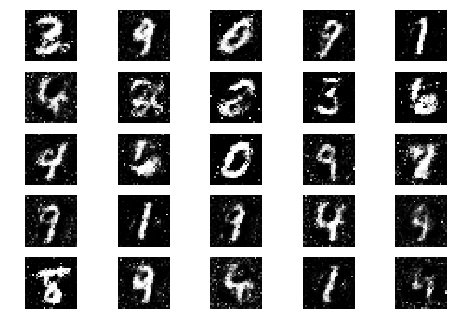

3700 loss_D 0.637374 loss_G 0.9305016


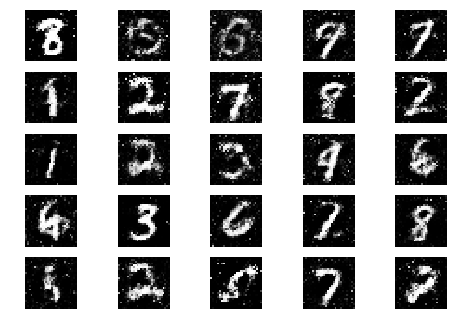

3800 loss_D 0.58898044 loss_G 0.95045984


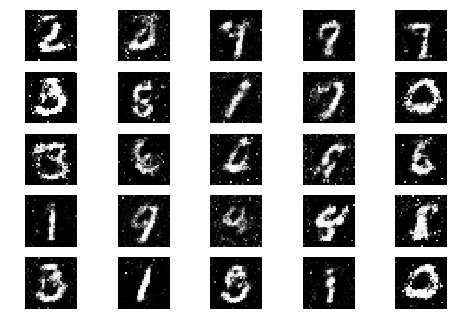

3900 loss_D 0.64669716 loss_G 0.9331458


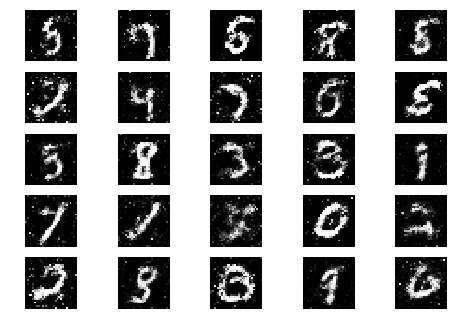

4000 loss_D 0.6370381 loss_G 0.9330925


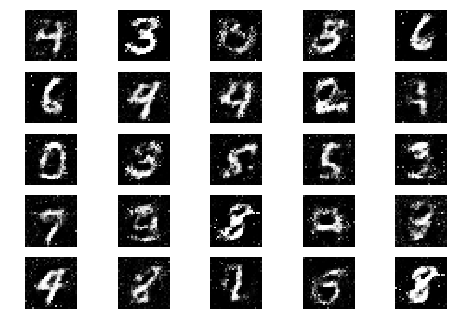

4100 loss_D 0.63995683 loss_G 0.9065555


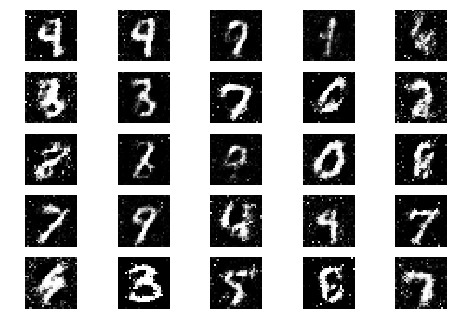

4200 loss_D 0.63437283 loss_G 0.90236616


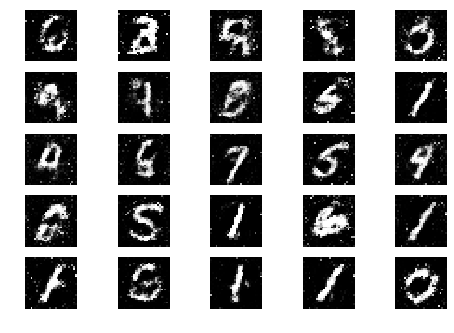

4300 loss_D 0.6162772 loss_G 0.9424254


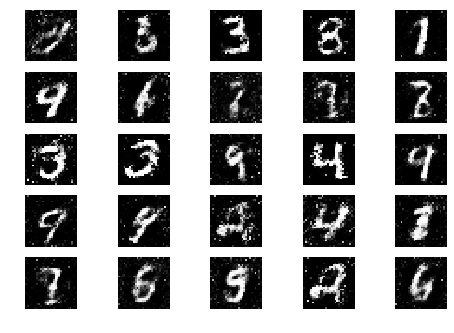

4400 loss_D 0.6191169 loss_G 0.9682137


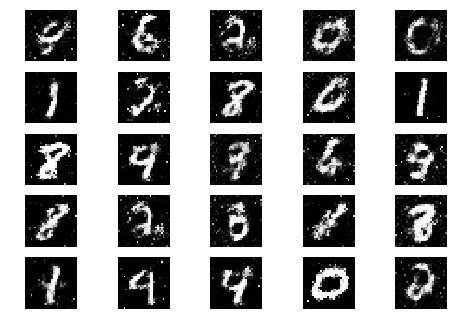

4500 loss_D 0.6389764 loss_G 0.92731094


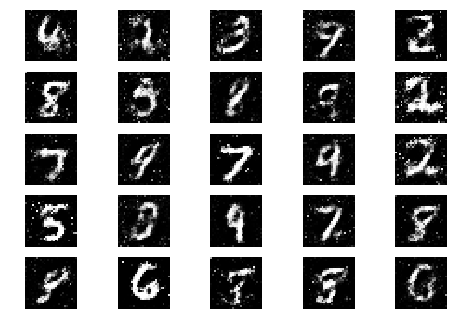

4600 loss_D 0.6488204 loss_G 0.8916303


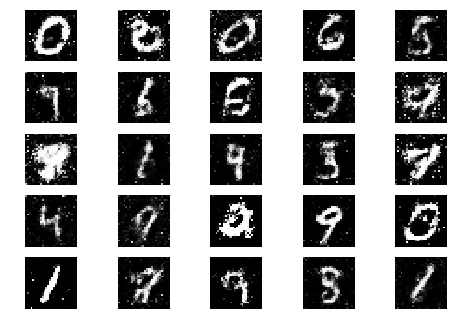

4700 loss_D 0.64807916 loss_G 0.9021657


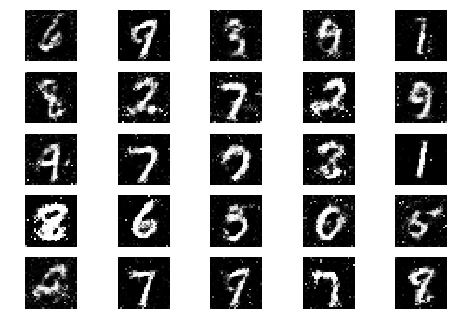

4800 loss_D 0.62037987 loss_G 0.98315823


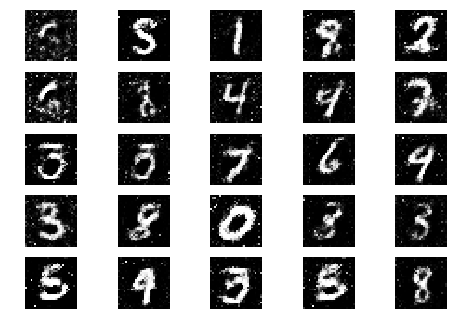

4900 loss_D 0.63553286 loss_G 0.94266427


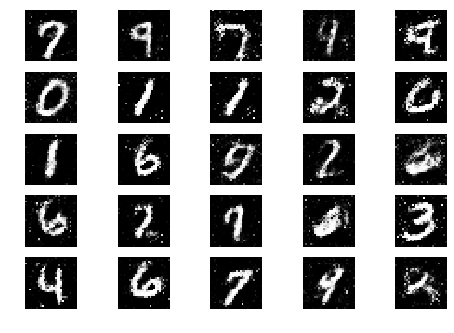

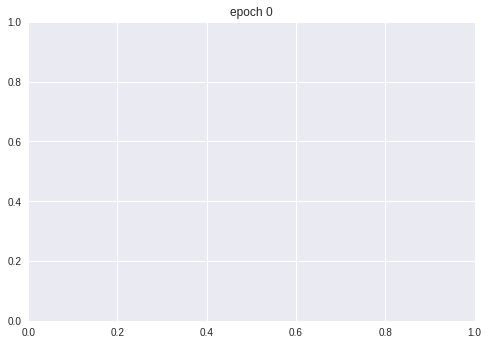

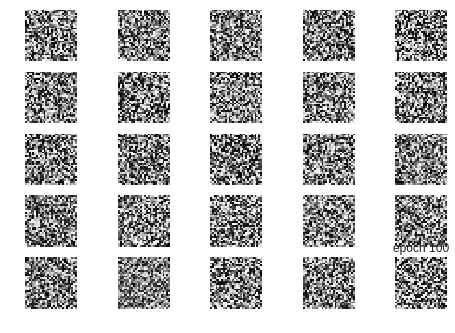

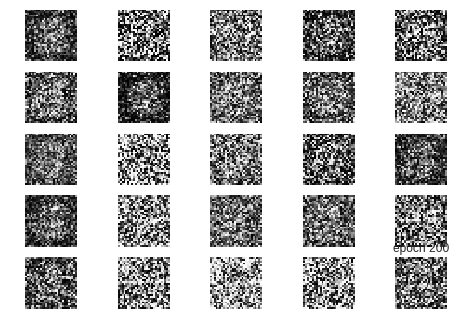

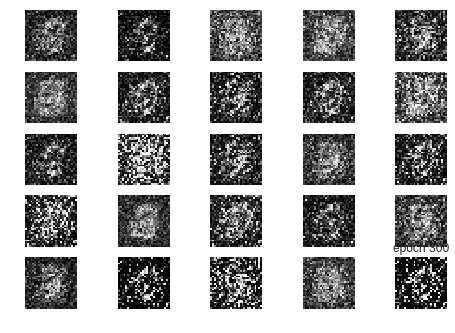

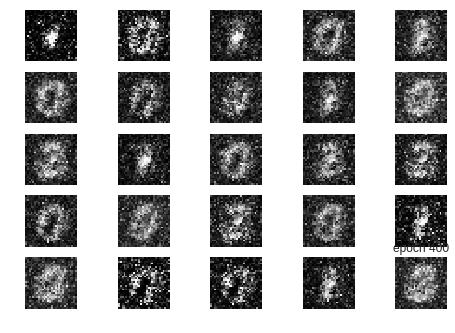

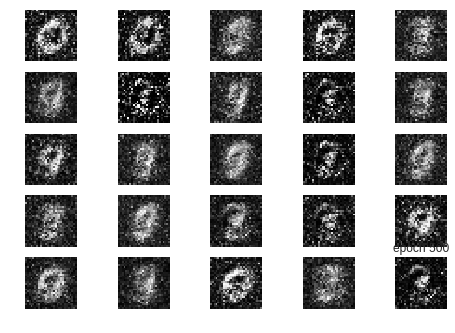

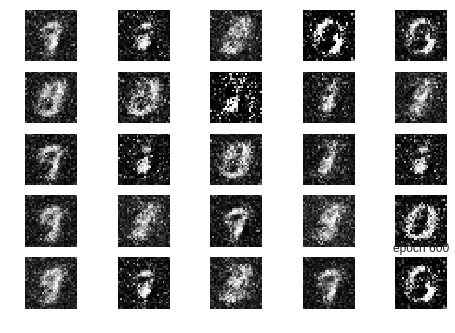

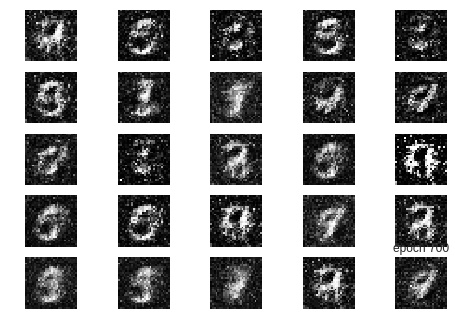

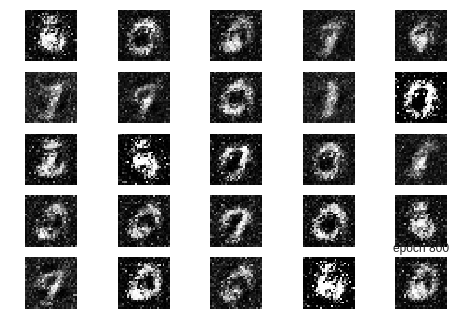

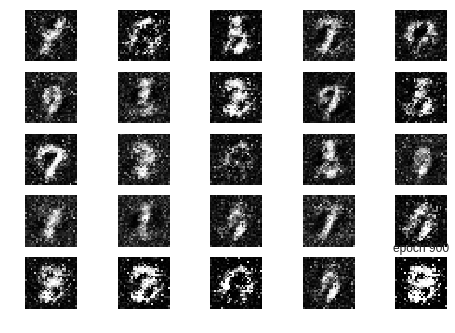

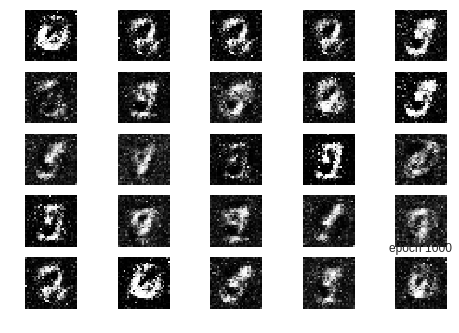

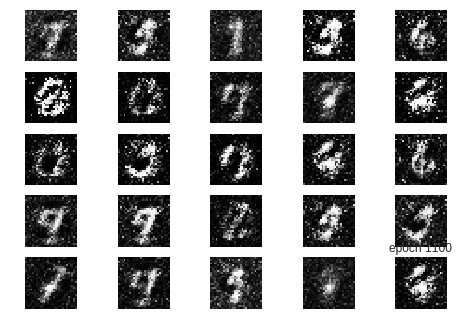

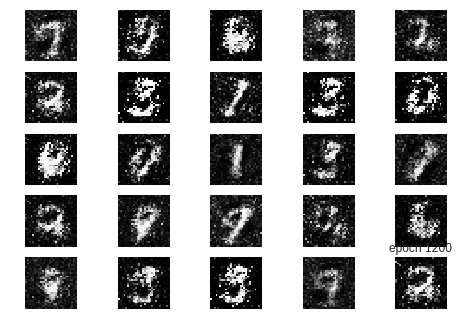

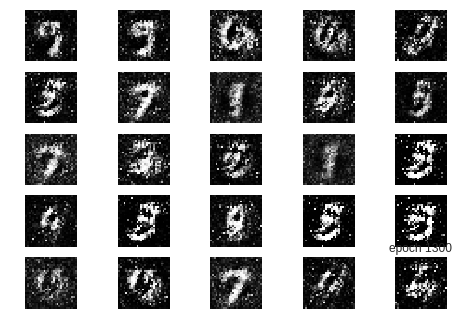

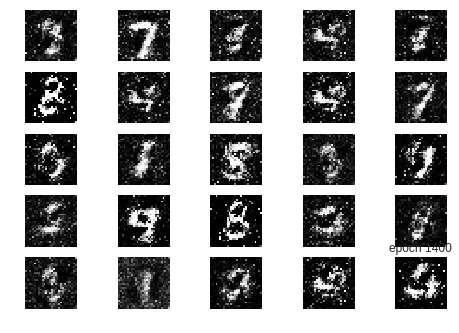

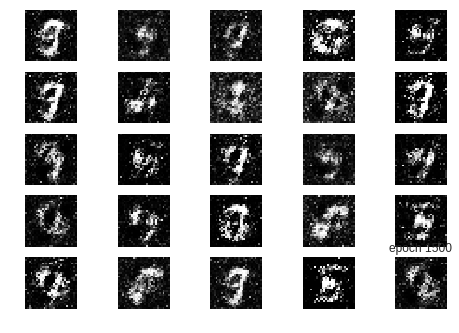

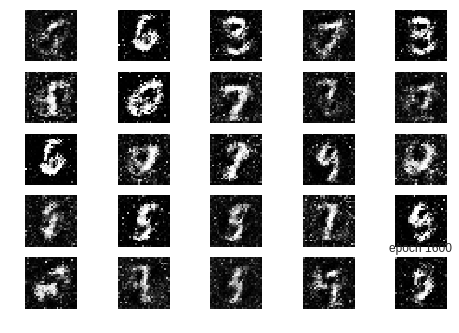

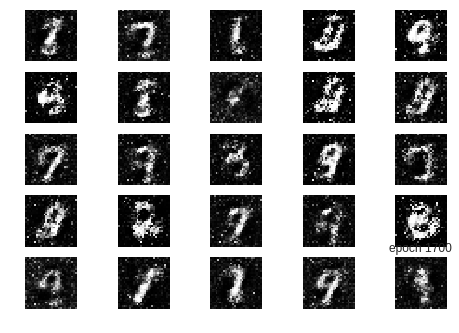

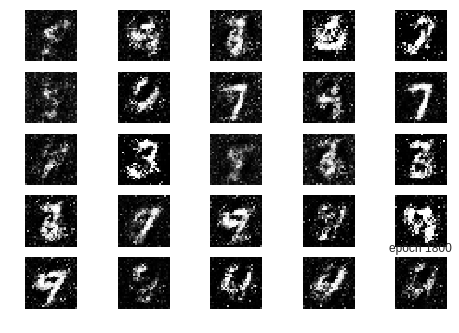

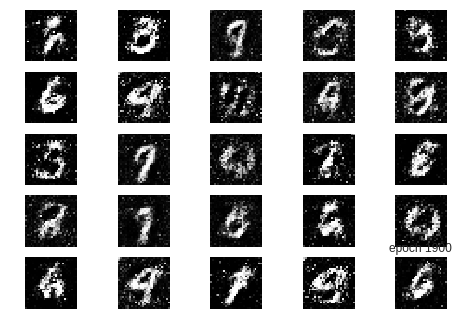

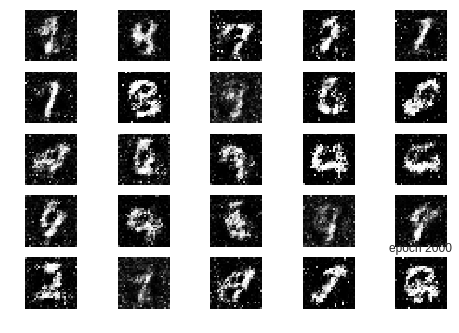

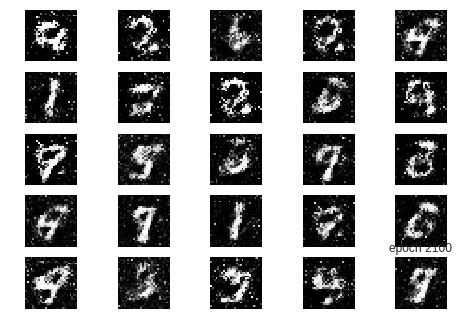

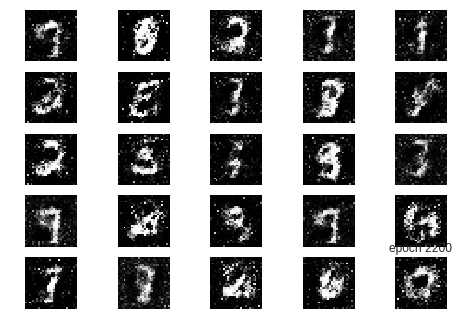

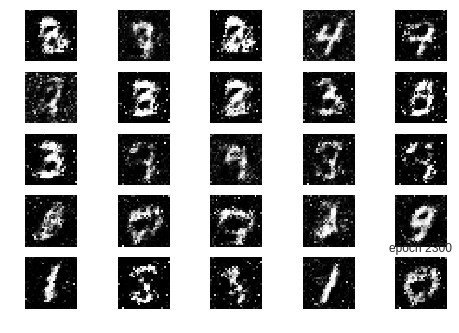

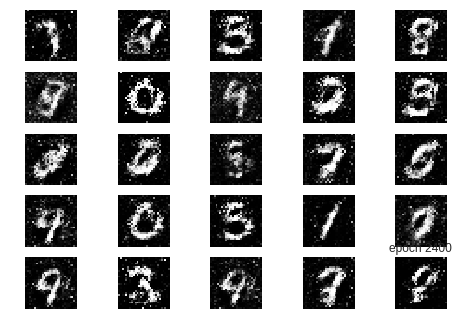

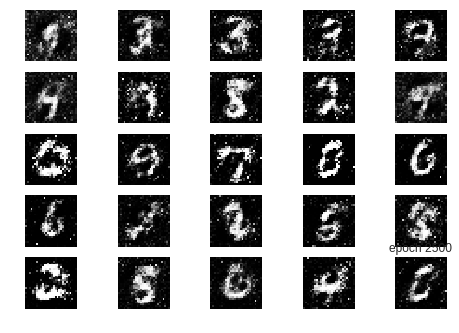

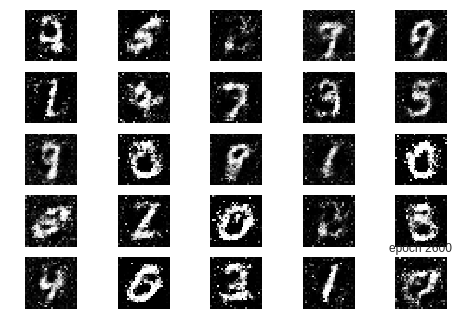

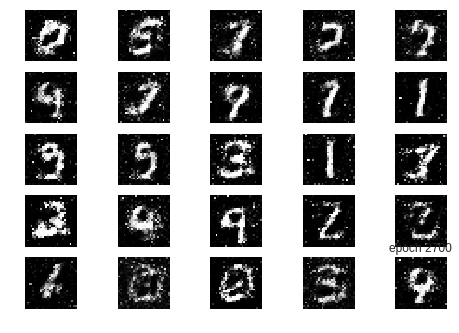

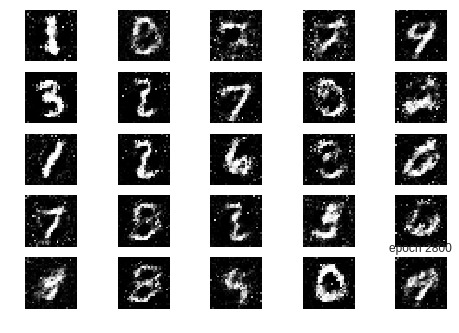

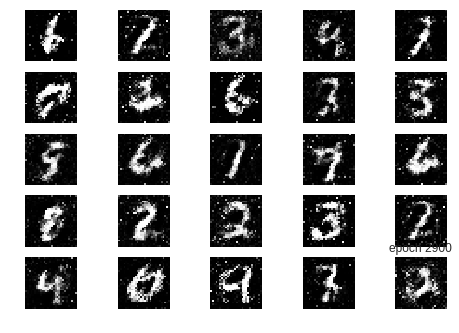

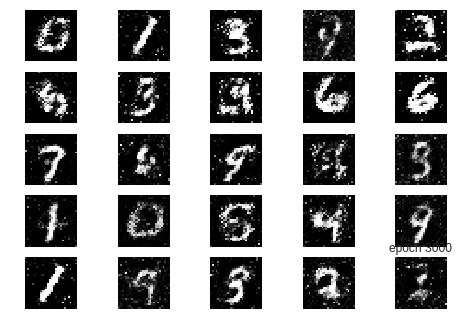

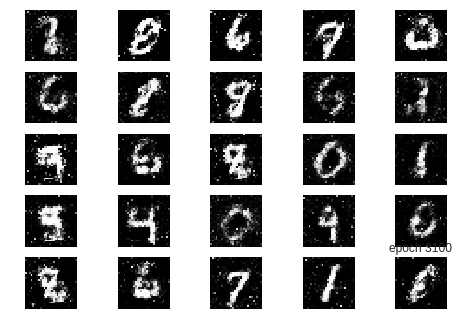

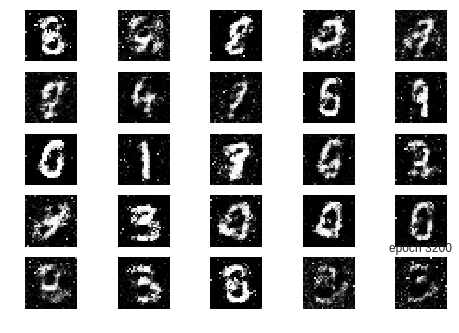

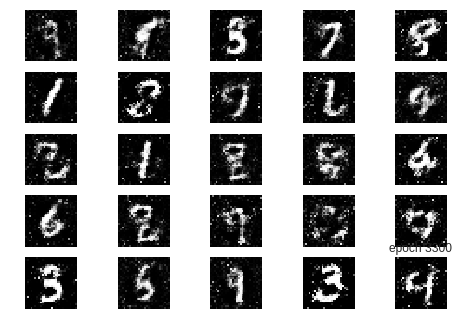

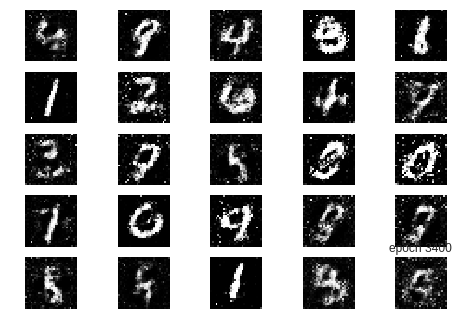

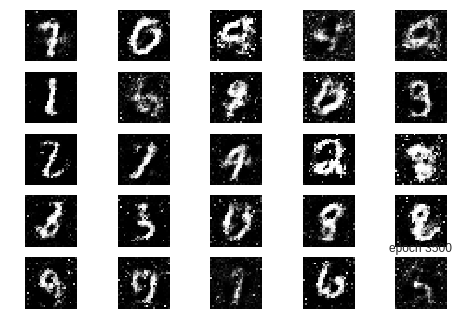

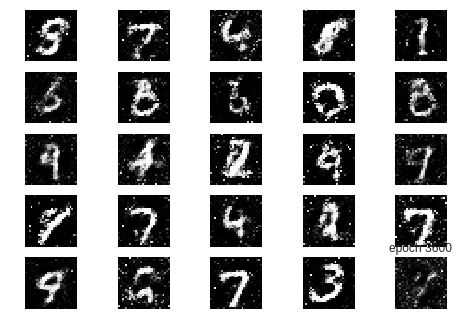

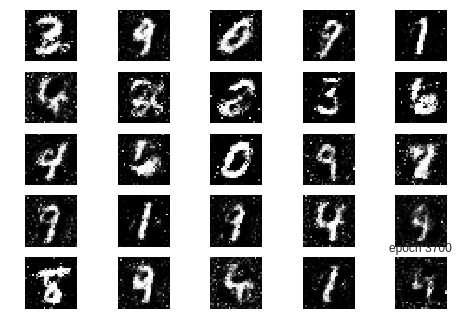

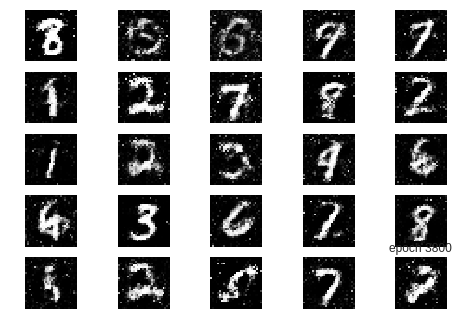

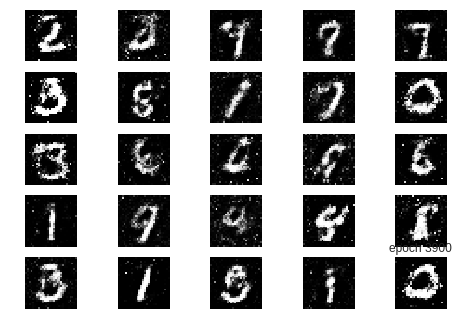

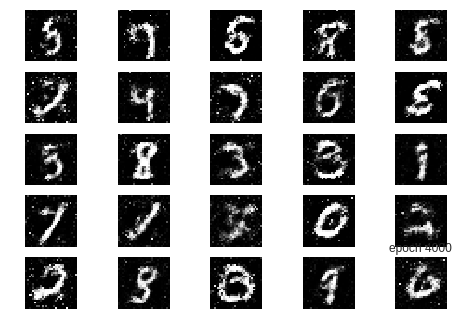

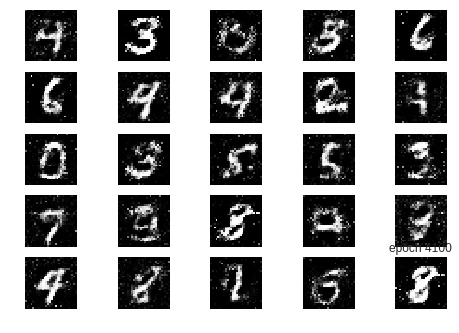

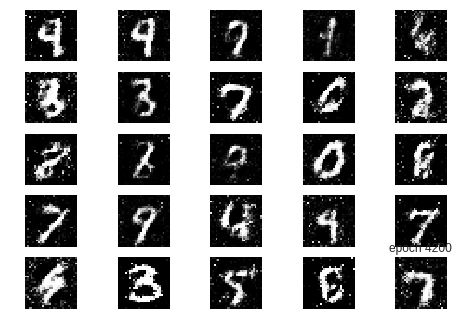

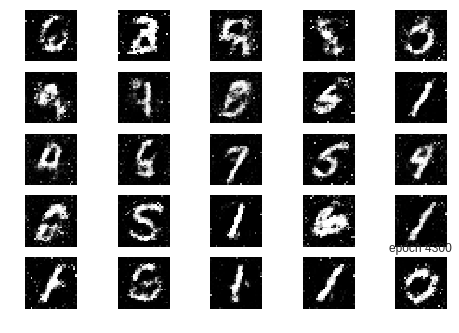

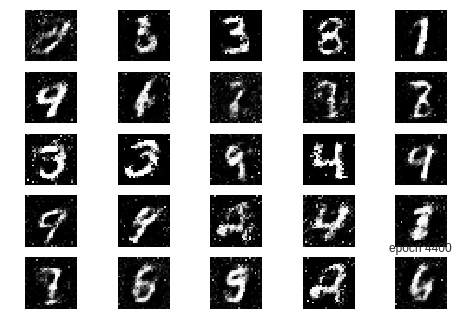

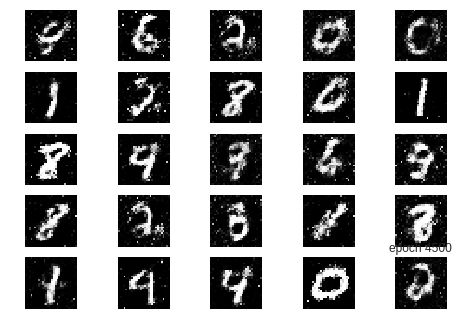

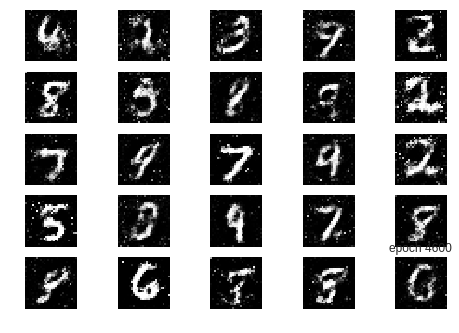

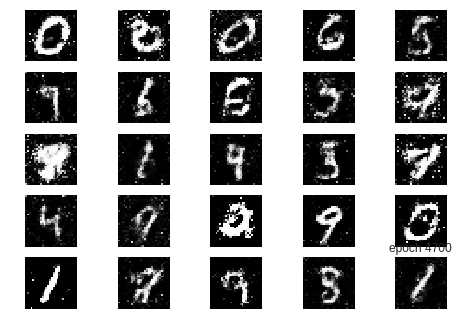

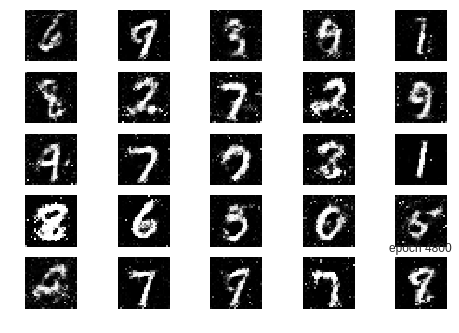

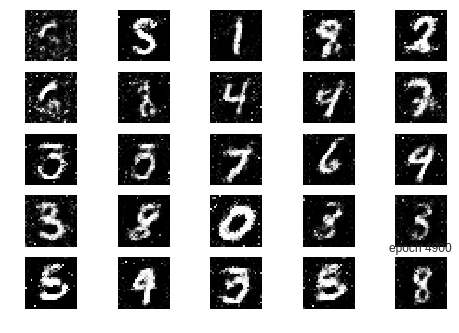

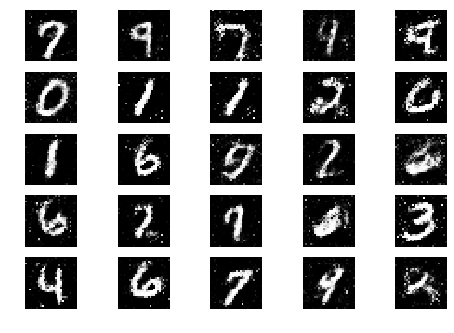

In [7]:
# G és D tanítása, kirajzolással

for epoch in range(5000):
    
  # képekből véletlen batch-nyi kiválasztása
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  imgs = x_train[idx]
  
  
  # egy batch-nyi kép generálás
  noise = np.random.normal(0, 1, (batch_size, gan.latent_dim))
  gen_imgs = gan.generator.predict(noise)
  
  # diszkriminátor tanítása
  d_loss_real = gan.discriminator.train_on_batch(imgs, valid)
  d_loss_fake = gan.discriminator.train_on_batch(gen_imgs, fake)
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
  
  
  # generátor tanítása
  g_loss = gan.combined.train_on_batch(noise, valid)
  
  # log
  if epoch % 100 == 0:
    print(epoch, 'loss_D', d_loss[0], 'loss_G', g_loss)
    
  # generált képek kirajzolása
  if epoch % 100 == 0:
    plot_images(gan, epoch)
    